## Tarea 7: Métodos Probabilísticos

Implementación en python de Aprendizaje No supervisado. Segmentación de imágenes empleando el modelo de mexcla de Gaussianas (MoG).
 
*   A partir de una imagen y proporcionando un valor $k$ (número de componentes) segmentar la imagen.
*   Usando el algoritmo Expectation Maximization (EM) determinar los parámetros del modelo MoG.

[Basado en: https://github.com/tmclouisluk/Expectation-maximization-Algorithm-on-Image-Segmentation/blob/master/EM_RGBScale_ImageSegment_Python.ipynb]

Se busca asignar una etiqueta discreta $\lbrace w_n\rbrace_{n=1}^N$ que tome uno de los $k$ valores para cada uno de los $N$ pixeles que conforman la imagen analizada, para los pixeles que pertenecen al mismo objeto se le asigna la misma etiqueta. El módelo de segmentación solo depende de los datos observados-conocidos, $\lbrace x_n\rbrace_{n=1}^N$,  donde $N$ representa el número de pixeles totales en la imagen,  caracterizados por sus valores RGB y coordenadas $x$ y $y$. A este problema se le denomina como aprendizaje no supervisado, se deben aprender los parámetros $\theta$ y estimar lo estados del mundo $\lbrace w_i\rbrace_{i=1}^I$ a partir de los datos de la imagen $\lbrace x_n\rbrace_{n=1}^N$. 

### Librerías

In [104]:
#import datetime
#from dateutil.relativedelta import relativedelta

import numpy as np
#from numpy.random import randint, random
import scipy.stats
#import math
#import cv2
#import imageio

from sklearn import cluster
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
from skimage import io
#from scipy import ndimage
#%matplotlib inline

### Funciones necesarias

In [105]:
def flat_img(img_3d):
  x, y, z = img_3d.shape
  img_2d = img_3d.reshape(x*y, z)
  img_2d = np.array(img_2d, dtype = np.float)
  return img_2d

### Paso de inicialización:
*   Generando espacio multiespectral

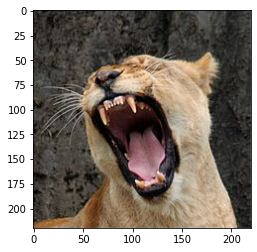

In [106]:
img_raw = io.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/Female_Lion.JPG/220px-Female_Lion.JPG')
rgb_list = []
dim_list = []
x, y, z = img_raw.shape
Kclusters = 5
dim_list.append((x,y,z))
rgb_list.append(img_raw)
img_flat = [flat_img(img_raw) for image in rgb_list]
plt.imshow(img_raw)

*   Función de creación de valores iniciales aleatorios ($\mu_1, \mu_2, \dots, \mu_k $, $Σ_1, Σ_2, \dots, Σ_k$) para usar en el algoritmo EM


In [107]:
def init_values(img, k):
    means, labels = kmeans2(img, k)
    means = np.array(means)
    cov = np.array([np.cov(img[labels == i].T) for i in range(k)])
    ids = set(labels)
    lambdas = np.array([np.sum([labels == i]) / len(labels) for i in ids])
    return means, cov, lambdas

In [108]:
# Visualización de los valores iniciales de cada función de probabilidad
for img in img_flat:
    means, cov, lambdas = init_values(img, Kclusters)
    print(means, "\n\n", cov, "\n\n", lambdas)

[[213.43945215 190.64840488 165.17638216]
 [134.9352471  109.86168651  87.04844234]
 [ 72.693594    66.48991762  59.99950818]
 [179.17492968 154.53393108 130.23030942]
 [ 36.57014238  31.79229481  28.29641262]] 

 [[[230.34326786 147.98012809 100.34562956]
  [147.98012809 177.30285537 149.50522627]
  [100.34562956 149.50522627 230.21278657]]

 [[308.15942791 160.12301624  43.05876535]
  [160.12301624 211.6069674  126.88288403]
  [ 43.05876535 126.88288403 274.23533648]]

 [[202.90100661 113.87855822  59.22462642]
  [113.87855822 116.6768427  102.69719762]
  [ 59.22462642 102.69719762 141.72185651]]

 [[212.6542896  119.15398955  50.05078989]
  [119.15398955 174.72858296 106.76623005]
  [ 50.05078989 106.76623005 226.06933263]]

 [[196.4625886  160.54245437 144.35098802]
  [160.54245437 194.287839   179.25337642]
  [144.35098802 179.25337642 185.02018117]]] 

 [0.12369835 0.12667355 0.33607438 0.11752066 0.29603306]


* Funciones principales para actualizar los parámetros media, covariancia y verosimilitud, así como el término $r_{ik}$ en cada iteración

In [109]:
def update_means(img, termIK):
    means = []
    class_n = termIK.shape[1]
    for j in range(class_n):
        weight = termIK[:, j] / np.sum(termIK[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        means_j = weight.dot(img)
        means.append(means_j[0])
    means = np.array(means)
    return means

In [110]:
def update_loglikelihood(img, means, cov, lambdas, k):
    pdf = np.array([lambdas[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j]) for j in range(k)])
    log_ll = np.log(np.sum(pdf, axis = 0))
    log_ll_sum = np.sum(log_ll)
    return log_ll_sum

In [111]:
def update_covariance(img, termIK, means):
    cov = []
    class_n = termIK.shape[1]
    for j in range(class_n):
        weight = termIK[:, j] / np.sum(termIK[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        covs = [np.mat(i - means[j]).T * np.mat(i - means[j]) for i in img]
        cov_j = sum(weight[0][i] * covs[i] for i in range(len(weight[0])))
        cov.append(cov_j)
    cov = np.array(cov)
    return cov

In [112]:
def Next_termIK(img, means, cov, lambdas, k):
    termIK = np.array([lambdas[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j]) for j in range(k)]).T
    norm = np.sum(termIK, axis = 1)
    norm = np.reshape(norm, (len(norm), 1))
    termIK = termIK / norm
    return termIK

**Paso Expectation (E):** 

Se usa el Teorema de Bayes para calcular la probabilidad de que cada $x_i$ pertenezca a cada uno de los $k$ modelos gaussianos $𝓖_k$  y se maximiza el límite con respecto a las distribuciones.

**Paso Mazimization (M):** 

Ya que se ha elegido el máximo se recalculan los parámetros $μ$ y $σ$ para cada modelo $𝓖_k$.

In [113]:
def EM_training(img, k, error = 10e-4, iter_n = 500):
  # Inicializando contador, verosimilitud, término r_ik, parámetros iniciales, lista vacía de verosimilitudes y medias. 
    counter = 0
    likelihood_step = []
    means_step = []
    means, cov, lambdas = init_values(img, k)
    likelihood = 0
    new_likelihood = 2
    means_step.append(means)
    termIK = Next_termIK(img, means, cov, lambdas, k)
  # Algoritmo de E-M
    while (abs(likelihood - new_likelihood) > error) and (counter <= iter_n):
        counter += 1
        likelihood = new_likelihood
        # M-Step
        labels = np.argmax(termIK, axis = 1)
        # E-step
        termIK = Next_termIK(img, means, cov, lambdas, k)
        means = update_means(img, termIK)
        cov = update_covariance(img, termIK, means)
        lambdas = np.sum(termIK, axis = 0) / termIK.shape[0]
        new_likelihood = update_loglikelihood(img, means, cov, lambdas, k)
        likelihood_step.append(new_likelihood)
        means_step.append(means)
    likelihood_step = np.array(likelihood_step)
    return labels, means, cov, lambdas, likelihood_step, means_step

In [114]:
# Barriendo el entrenamiento EM sobre nuestro espacio multiespectral
em_img_list = []
for img, dim in zip(img_flat, dim_list):
    labels, means, cov, lambdas, likelihood_steps, means_arr = EM_training(img, Kclusters, error = 0.01)
    means = np.array([element[0] for element in means])
    cov = [element[0][0] for element in cov]
    em_img = means[labels]
    recover_img = em_img.reshape(dim[0], dim[1])
    em_img_list.append(recover_img)

/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


KeyboardInterrupt: ignored

In [ ]:
#Visualización del resultado
for kmeans_img, dim in zip(em_img_list, dim_list):
    plt.imshow(kmeans_img)